In [11]:
import time
import numpy as np
import numpy as np
from keras.datasets import cifar100
import matplotlib.pyplot as plt
import cv2

# centre the data
def centre_data(train, validation, test):
    
    # calculate the means for each attribute of the training data
    column_means = np.mean(train, axis=0) 
    
    # centre training data by subtracting training data attribute means
    for i in range(len(train)):
        train[i] = train[i] - column_means
    
    # centre testing data by subtracting training data attribute means
    for x in range(len(test)):
        test[x] = test[x] - column_means
        
    for x in range(len(validation)):
        validation[x] = validation[x] - column_means
        
    return train, test, validation

# apply PCA on the data 
def PCA(variance_target, training_data, validation_data, testing_data):

    U, sigma, Vt = np.linalg.svd(training_data, full_matrices=False)
    
    sum_square_singular = np.sum(sigma**2)
    
    ratios = sigma**2/sum_square_singular
    n_components = 0
    explained_variance = 0
    
    # determine how many principle components must be retained to maintain the target level of explained variance
    for i in range(len(ratios)):
        if explained_variance >= variance_target:
            break
        else: 
            n_components += 1
            explained_variance += ratios[i]
    
    return training_data.dot(Vt.T[:, :n_components]), testing_data.dot(Vt.T[:, :n_components]), validation_data.dot(Vt.T[:, :n_components])


# calculate gradient, use L2 regularisation 
def calculate_gradient(weights, regularisation_param, training_data, training_labels, num_classes):
    
    num_training_samples, num_training_features = training_data.shape
    
    gradient = np.zeros(num_training_features, num_classes)
    
    # w^Tx
    linear_output = np.dot(training_data, weights)

    #linear output with labels 
    linear_output_y_i = linear_output[np.arange(num_training_samples),training_labels]
  # distance of point from separating hyperplane?
    # np.newaxis here makes it a column vector 
    # calculate distance?
    
    # distances = y * (np.dot(X, w)) - 1
    delta = linear_output - linear_output_y_i[:,np.newaxis] + 1
    
    ones_and_zeros = np.zeros(delta.shape)
    
    # makes all the places where delta > 0, 1 else 0
    # With lagrange multiplier considered, if the sample is on the support vector: 𝛼 = 1
    # else: 𝛼 = 0
    ones_and_zeros = np.where(delta > 0, 1, 0)
    
    # calculate the sum of each row 
    sum_of_each_row = np.sum(ones_and_zeros, axis=1)
    
    ones_and_zeros[np.arange(num_training_samples), training_labels] = - sum_of_each_row

    gradient = (1/num_training_samples) * np.dot((training_data.T), ones_and_zeros)
    
    # controls the influence of each individual support vector on the objective function. 
    # Greater C decreases the effect of |w|²/2, and results in the narrower margin
    gradient = gradient + (2* regularisation_param * weights)
    
    return gradient 

# train model using stochastic gradient descent 
def train_model(training_data, training_labels, weights, learning_rate, regularisation_param, iterations, batch_size, num_classes):
  
  # number of examples in each batch
  #batch_size = 200
    num_training_samples = len(training_data)
    weights = weights
    for i in range(iterations):
    # create batch
        batch = np.random.choice(num_training_samples, batch_size)
        gradient = calculate_gradient(weights, regularisation_param, training_data[batch], training_labels[batch], num_classes)
        weights = weights - learning_rate * gradient
    return weights

# calculate accuracy of model 
def calculate_accuracy (data, labels, weights):
    accuracy = 0

    prediction = np.zeros(len(data))

  #w^Tx
    linear_output = np.dot(data, weights)

  # returns the indices of the maximum values along an axis, ie. in this case will return the 
  # column index corresponding to the greatest index of each row
    prediction = np.argmax(linear_output, axis=1)

  # count the number of predictions that are correct 
    total_correct_predictions = (prediction == labels).sum()
    num_data_points = len(data)

    accuracy = (total_correct_predictions/num_data_points)*100

    return accuracy


startTime = time.time()

def increase_image_contrast(image):
    xp = [0, 64, 128, 192, 255]
    fp = [0, 16, 128, 240, 255]
    x = np.arange(256)
    table = np.interp(x, xp, fp).astype('uint8')
    return cv2.LUT(image, table)

def increase_all_contrast(train, test):
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = increase_image_contrast(train[i])
    for i in range(len(test)):
        new_test[i] = increase_image_contrast(test[i])
    return new_train, new_test

# helper function for concatenating labels onto their corresponding data points
def concatenate_data(training_data, training_labels):
    return np.column_stack((training_data, training_labels))

# data set is randomised and then split in a 70:30 ratio for training:validation sets
def split_into_validation_training(training_matrix):
    
    import random
    random.shuffle(training_matrix)

    training_set = training_matrix[:int(len(training_matrix)*0.7)]
    validation_set = training_matrix[int(len(training_matrix)*0.7):]
    
    return training_set, validation_set

def load_in_dataset_and_preprocess(explained_variance):
  
    (training_data, training_labels), (testing_data, testing_labels) = (cifar100.load_data("coarse"))
    
    # reshape the data 
    training_data = training_data.reshape(50000, 3072)
    testing_data = testing_data.reshape(10000, 3072)

    concatenated_training = concatenate_data(training_data, training_labels)

    training_set, validation_set = split_into_validation_training(concatenated_training)

    training_data = training_set[:, :-1]
    training_labels = np.squeeze(training_set[:, -1])

    validation_data = validation_set[:, :-1]
    validation_labels = np.squeeze(validation_set[:, -1])

    training_data = training_data.astype('float32')
    testing_data = testing_data.astype('float32')
    validation_data = validation_data.astype('float32')

    # Centre data
    #training_data, testing_data, validation_data = centre_data(training_data, testing_data, validation_data)

    # Apply PCA
    #training_data, testing_data, validation_data = PCA(explained_variance, training_data, testing_data, validation_data)

    number_training_samples = len(training_data)
    number_validation_samples = len(validation_data)
    number_testing_samples = len(testing_data)

    # Reshape data from channel to rows
    training_data = np.reshape(training_data, (number_training_samples, -1))
    validation_data = np.reshape(validation_data, (number_validation_samples, -1))
    testing_data = np.reshape(testing_data, (number_testing_samples, -1))

    return training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels


In [5]:
import time
import numpy as np
import numpy as np
from keras.datasets import cifar100
import matplotlib.pyplot as plt
import cv2

class SVM:

    training_data=[]
    testing_data=[]

    def __init__(self, training_data, testing_data):
      self.training_data= training_data
      self.testing_data= testing_data

    def __len__(self, data):
      return len(data)

    def calculate_linear_output(self, data, weights):
      return np.dot(data, weights)

    # distance of point from separating hyperplane?
    def calculate_distance(self, X, w):
      return  y * (np.dot(X, w)) - 1

    # calculate gradient, use L2 regularisation 
    def calculate_gradient(self, weights, regularisation_param, training_data, training_labels, num_classes):
        
        num_training_samples, num_training_features = training_data.shape
        
        gradient = np.zeros((num_training_features, num_classes))
        
        # w^Tx
        linear_output = self.calculate_linear_output(training_data, weights)

        #linear output with labels 
        linear_output_y_i = linear_output[np.arange(num_training_samples),training_labels]
        delta = linear_output - linear_output_y_i[:,np.newaxis] + 1
        
        ones_and_zeros = np.zeros(delta.shape)
        
        # makes all the places where delta > 0, 1 else 0
        # With lagrange multiplier considered, if the sample is on the support vector: 𝛼 = 1
        # else: 𝛼 = 0
        ones_and_zeros = np.where(delta > 0, 1, 0)
        
        # calculate the sum of each row 
        sum_of_each_row = np.sum(ones_and_zeros, axis=1)
        
        ones_and_zeros[np.arange(num_training_samples), training_labels] = - sum_of_each_row

        gradient = (1/num_training_samples) * np.dot((training_data.T), ones_and_zeros)
        
        # controls the influence of each individual support vector on the objective function. 
        # Greater C decreases the effect of |w|²/2, and results in the narrower margin
        gradient = gradient + (2* regularisation_param * weights)
        
        return gradient 

    # train model using stochastic gradient descent 
    def train_model(self, training_data, training_labels, weights, learning_rate, regularisation_param, iterations, batch_size, num_classes):
      
      num_training_samples = len(training_data)
      weights = weights

      for i in range(iterations):
      # create batch
          batch = np.random.choice(num_training_samples, batch_size)
          gradient = self.calculate_gradient(weights, regularisation_param, training_data[batch], training_labels[batch], num_classes)
          weights = weights - learning_rate * gradient

      return weights

    # calculate accuracy of model 
    def calculate_accuracy (self, data, labels, weights):
        
        accuracy = 0
        prediction = np.zeros(len(data))

      #w^Tx
        linear_output= self.calculate_linear_output(data, weights)

      # returns the indices of the maximum values along an axis, ie. in this case will return the 
      # column index corresponding to the greatest index of each row
        prediction = np.argmax(linear_output, axis=1)

      # count the number of predictions that are correct 
        total_correct_predictions = (prediction == labels).sum()
        num_data_points = len(data)
        accuracy = (total_correct_predictions/num_data_points)*100

        return accuracy


# centre the data
def centre_data(train, validation, test):
    
    # calculate the means for each attribute of the training data
    column_means = np.mean(train, axis=0) 
    
    # centre training data by subtracting training data attribute means
    for i in range(len(train)):
        train[i] = train[i] - column_means
    
    # centre testing data by subtracting training data attribute means
    for x in range(len(test)):
        test[x] = test[x] - column_means
        
    for x in range(len(validation)):
        validation[x] = validation[x] - column_means
        
    return train, test, validation

# apply PCA on the data 
def PCA(variance_target, training_data, validation_data, testing_data):

    U, sigma, Vt = np.linalg.svd(training_data, full_matrices=False)
    
    sum_square_singular = np.sum(sigma**2)
    
    ratios = sigma**2/sum_square_singular
    n_components = 0
    explained_variance = 0
    
    # determine how many principle components must be retained to maintain the target level of explained variance
    for i in range(len(ratios)):
        if explained_variance >= variance_target:
            break
        else: 
            n_components += 1
            explained_variance += ratios[i]
    
    return training_data.dot(Vt.T[:, :n_components]), testing_data.dot(Vt.T[:, :n_components]), validation_data.dot(Vt.T[:, :n_components])



# helper function for concatenating labels onto their corresponding data points
def concatenate_data(training_data, training_labels):
    return np.column_stack((training_data, training_labels))

# data set is randomised and then split in a 70:30 ratio for training:validation sets
def split_into_validation_training(training_matrix):
    
    import random
    random.shuffle(training_matrix)

    training_set = training_matrix[:int(len(training_matrix)*0.7)]
    validation_set = training_matrix[int(len(training_matrix)*0.7):]
    
    return training_set, validation_set

def load_in_dataset_and_preprocess(explained_variance):
  
    (training_data, training_labels), (testing_data, testing_labels) = (cifar100.load_data("coarse"))
    
    # reshape the data 
    training_data = training_data.reshape(50000, 3072)
    testing_data = testing_data.reshape(10000, 3072)

    concatenated_training = concatenate_data(training_data, training_labels)

    training_set, validation_set = split_into_validation_training(concatenated_training)

    training_data = training_set[:, :-1]
    training_labels = np.squeeze(training_set[:, -1])

    validation_data = validation_set[:, :-1]
    validation_labels = np.squeeze(validation_set[:, -1])

    training_data = training_data.astype('float32')
    testing_data = testing_data.astype('float32')
    validation_data = validation_data.astype('float32')

    # Centre data
    training_data, testing_data, validation_data = centre_data(training_data, testing_data, validation_data)

    # Apply PCA
    training_data, testing_data, validation_data = PCA(explained_variance, training_data, testing_data, validation_data)

    number_training_samples = len(training_data)
    number_validation_samples = len(validation_data)
    number_testing_samples = len(testing_data)

    # Reshape data from channel to rows
    training_data = np.reshape(training_data, (number_training_samples, -1))
    validation_data = np.reshape(validation_data, (number_validation_samples, -1))
    testing_data = np.reshape(testing_data, (number_testing_samples, -1))

    return training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels


training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
svm = SVM(training_data, testing_data)
num_classes = np.max(training_labels) + 1
weights = np.ones((len(training_data[0]), num_classes))
weights= svm.train_model(training_data, training_labels, weights, 0.0000001, 5000, 15000, 200, 20)

total_accuracy = svm.calculate_accuracy(validation_data, validation_labels, weights)
print(total_accuracy)

21.52


**Preprocessing Techniques**

In [12]:
from skimage import exposure
from skimage import feature
import keras


def convert_to_grayscale(train, test):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    gray_train = np.dot(train[:][...,:3], rgb_weights)
    gray_test = np.dot(test[:][...,:3], rgb_weights)
    return gray_train.astype(int), gray_test.astype(int)

def increase_image_contrast(image, strength):
    p_low, p_high = np.percentile(image, (strength, 100 - strength))
    return (exposure.rescale_intensity(image, in_range=(p_low, p_high))).astype(int)

def increase_all_contrast(train, test, strength=10):
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = increase_image_contrast(train[i], strength)
    for i in range(len(test)):
        new_test[i] = increase_image_contrast(test[i], strength)
    return new_train, new_test

def equalize_hist(image):
    return (exposure.equalize_hist(image) * 255).astype(int)

def equalize_hist_all(train, test):
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = equalize_hist(train[i])
    for i in range(len(test)):
        new_test[i] = equalize_hist(test[i])
    return new_train, new_test

def equalize_adapthist(image, clip_lim):
    return (exposure.equalize_adapthist(image, clip_limit=clip_lim) * 255).astype(int)

def equalize_adapthist_all(train, test, clip_limit=0.03):
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = equalize_adapthist(train[i], clip_limit)
    for i in range(len(test)):
        new_test[i] = equalize_adapthist(test[i], clip_limit)
    return new_train, new_test

def canny_edge_filter_all(train, test, sig=1):
    if (len(train.shape) > 3):
        train, test = convert_to_grayscale(train, test)
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = feature.canny(train[i].astype(float), sigma=sig)
    for i in range(len(test)):
        new_test[i] = feature.canny(test[i].astype(float), sigma=sig)
    return new_train, new_test

def autoencoder(training_data, testing_data):

  from keras import layers

  dimension = 32 
  input_image = keras.Input(shape=(3072,)) #3072

  encoded = layers.Dense(dimension, activation='relu')(input_image)
  decoded = layers.Dense(3072, activation='sigmoid')(encoded)

  autoencoder = keras.Model(input_image, decoded)
  encoder = keras.Model(input_image, encoded)
  input_encode = keras.Input(shape=(dimension,))
  layers = autoencoder.layers[-1]

  decoder = keras.Model(input_encode, layers(input_encode))
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

  autoencoder.fit(training_data, training_data,
                  epochs=50,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(testing_data, testing_data))

  test_encoded = encoder.predict(testing_data)
  train_encoded = encoder.predict(training_data)
  decoded_test = decoder.predict(test_encoded)
  decoded_train= decoder.predict(train_encoded)

  return decoded_train, decoded_test


def flatten_data(x_train, y_train, x_test, y_test):
    new_image_shape = 1
    for dim in range(1, len(x_train.shape)):
        new_image_shape *= x_train.shape[dim]
        
    flat_x_train = x_train.reshape((x_train.shape[0], new_image_shape))
    flat_y_train = np.ravel(y_train)
    
    flat_x_test = x_test.reshape((x_test.shape[0], new_image_shape))
    flat_y_test = np.ravel(y_test)
    return flat_x_train, flat_y_train, flat_x_test, flat_y_test

# Testing 

In [13]:
import time
import numpy as np
import numpy as np
from keras.datasets import cifar100
import matplotlib.pyplot as plt
import cv2
import csv
import tensorflow as tf

**Testing weight parameter**

In [14]:
import tensorflow as tf
import time
import csv

def nano_to_seconds(nanoseconds):
    """Converts nanoseconds to seconds rounded to the nearest 5 decimal places.
    
    Parameters
    ----------
    nanoseconds : int
        The nanoseconds to convert
    """

    return np.round((nanoseconds / 1e+9), 5)

In [ ]:
def test_svm_weights():

  training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)

  num_classes = np.max(training_labels) + 1
  weights1 = np.ones((len(training_data[0]), num_classes))
  weights2 = np.ones((len(training_data[1]), num_classes))
  weights3 = np.ones((len(training_data[2]), num_classes))

  weights_list = [weights1, weights2, weights3]

  with open('svm_learning_rates.csv', mode='w', newline='') as csv_file:
    
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Weights', 'Learning Rate', 'Regularisation Parameters', 'Iterations', 'Batch Size', 'Average Accuracy', 'Average Runtime'])
        reg_param= 50000
        iterations= 15000
        batch_size=200
        learning_rate= 0.00000001

        for n_weight in weights_list:
          i=0
          num_tests = 0
          total_accuracy = 0
          total_runtime = 0

          for i in range(2):
              start_time = time.time()
              res_weights = train_model(training_data, training_labels, n_weight, learning_rate, reg_param, iterations,batch_size, num_classes)
              total_accuracy += calculate_accuracy(validation_data, validation_labels, res_weights)
              print(total_accuracy)
              training_time = time.time() - startTime
              total_runtime += nano_to_seconds(training_time)
              num_tests += 1

          avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
          avg_runtime = np.round(total_runtime / float(num_tests), 5)
          result_writer.writerow([i, learning_rate, reg_param, iterations, batch_size, avg_accuracy, avg_runtime])
          i += 1

test_svm_weights()

21.279999999999998
42.53333333333333
22.52
43.74666666666667
22.03333333333333
43.85333333333333


**Testing learning rate**

In [ ]:
import csv 
def test_svm_learning_rate():
    
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    
    num_classes = np.max(training_labels) + 1

    learning_rates = [0.00001, 0.00000001, 0.0000000001, 0.00000000001]
    
    weights = np.ones((len(training_data[0]), num_classes))

    with open('svm_learning_rates.csv', mode='w', newline='') as csv_file:
    
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Weights', 'Learning Rate', 'Regularisation Parameters', 'Iterations', 'Batch Size', 'Average Accuracy', 'Average Runtime'])
        reg_param= 50000
        iterations= 15000
        batch_size=200

        for n_learning_rate in learning_rates:
                num_tests = 0
                total_accuracy = 0
                total_runtime = 0

                for i in range(2):
                    start_time = time.time()
                    res_weights = train_model(training_data, training_labels, weights, n_learning_rate, reg_param, iterations,batch_size, num_classes)
                    total_accuracy += calculate_accuracy(validation_data, validation_labels, res_weights)
                    print(total_accuracy)
                    training_time = time.time() - startTime
                    total_runtime += nano_to_seconds(training_time)
                    num_tests += 1

                avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
                avg_runtime = np.round(total_runtime / float(num_tests), 5)
                result_writer.writerow(['Weight Set', n_learning_rate, reg_param, iterations, batch_size, avg_accuracy, avg_runtime])

test_svm_learning_rate()

6.12
11.346666666666668
20.34
39.49333333333333
19.553333333333335
39.24
10.12
20.366666666666667


**Testing regularisation parameter**

In [ ]:
import csv 
def test_svm_reg_param():
    
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    
    num_classes = np.max(training_labels) + 1

    reg_params = [1000,5000,7000,9000]
    
    weights = np.ones((len(training_data[0]), num_classes))

    with open('svm_reg_param.csv', mode='w', newline='') as csv_file:
    
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Weights', 'Learning Rate', 'Regularisation Parameters', 'Iterations', 'Batch Size', 'Average Accuracy', 'Average Runtime'])
        iterations= 15000
        learning_rate= 0.00000001
        batch_size=200

        for n_reg_param in reg_params:
                num_tests = 0
                total_accuracy = 0
                total_runtime = 0

                for i in range(2):
                    start_time = time.time()
                    res_weights = train_model(training_data, training_labels, weights, learning_rate, n_reg_param, iterations,batch_size, num_classes)
                    total_accuracy += calculate_accuracy(validation_data, validation_labels, res_weights)
                    print(total_accuracy)
                    training_time = time.time() - startTime
                    total_runtime += nano_to_seconds(training_time)
                    num_tests += 1

                avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
                avg_runtime = np.round(total_runtime / float(num_tests), 5)
                result_writer.writerow(['Weight Set', learning_rate, n_reg_param, iterations, batch_size, avg_accuracy, avg_runtime])

test_svm_reg_param()

24.44
49.29333333333334
23.56
47.72666666666667
23.7
47.04
23.48
47.21333333333334


**Testing iterations**

In [ ]:
import csv 
def test_svm_iterations():
    
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    
    num_classes = np.max(training_labels) + 1

    iterations= [15000, 20000, 30000, 40000]
    
    weights = np.ones((len(training_data[0]), num_classes))

    with open('svm_iterations.csv', mode='w', newline='') as csv_file:
    
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Weights', 'Learning Rate', 'Regularisation Parameters', 'Iterations', 'Batch Size', 'Average Accuracy', 'Average Runtime'])
        reg_param= 50000
        batch_size=200
        learning_rate= 0.00000001

        for n_iteration in iterations:
                num_tests = 0
                total_accuracy = 0
                total_runtime = 0

                for i in range(2):
                    start_time = time.time()
                    res_weights = train_model(training_data, training_labels, weights, learning_rate, reg_param, n_iteration,batch_size, num_classes)
                    total_accuracy += calculate_accuracy(validation_data, validation_labels, res_weights)
                    print(total_accuracy)
                    training_time = time.time() - startTime
                    total_runtime += nano_to_seconds(training_time)
                    num_tests += 1

                avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
                avg_runtime = np.round(total_runtime / float(num_tests), 5)
                result_writer.writerow(['Weight Set', learning_rate, reg_param, n_iteration, batch_size, avg_accuracy, avg_runtime])

test_svm_iterations()

21.226666666666667
43.519999999999996
23.119999999999997
45.306666666666665
22.186666666666667
44.71333333333334
21.786666666666665
43.44


**Testing batch size**

In [ ]:
import csv 
def test_svm_batch_size():
    
    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    
    num_classes = np.max(training_labels) + 1

    batch_sizes= [200, 400, 600]
    
    weights = np.ones((len(training_data[0]), num_classes))

    with open('svm_batch_size.csv', mode='w', newline='') as csv_file:
    
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Weights', 'Learning Rate', 'Regularisation Parameters', 'Iterations', 'Batch Size', 'Average Accuracy', 'Average Runtime'])
        reg_param= 50000
        iterations= 15000
        learning_rate= 0.00000001

        for n_batch_size in batch_sizes:
                num_tests = 0
                total_accuracy = 0
                total_runtime = 0

                for i in range(2):

                    start_time = time.time()
                    res_weights = train_model(training_data, training_labels, weights, learning_rate, reg_param, iterations,n_batch_size, num_classes)
                    total_accuracy += calculate_accuracy(validation_data, validation_labels, res_weights)
                    print(total_accuracy)
                    training_time = time.time() - startTime
                    total_runtime += nano_to_seconds(training_time)
                    num_tests += 1

                avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
                avg_runtime = np.round(total_runtime / float(num_tests), 5)
                result_writer.writerow(['Weight Set', learning_rate, reg_param, iterations, n_batch_size, avg_accuracy, avg_runtime])

test_svm_batch_size()

**Testing All Preprocessing Techniques**

In [15]:
def test_svm_preprocessing_functions():

    training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(0.8)
    num_classes = np.max(training_labels) + 1
    techniques = ['none', 'hist equalization','adaptive equalisation', 'autoencoder' ] 

    weights = np.ones((len(training_data[0]), num_classes))

    with open('svm_preprocessing.csv', mode='w', newline='') as csv_file:
      
      result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      result_writer.writerow(['Weights', 'Learning Rate', 'Regularisation Parameters', 'Iterations', 'Batch Size', 'Average Accuracy', 'Average Runtime'])
      reg_param= 50000
      iterations= 15000
      learning_rate= 0.00000001
      batch_size=200

      for technique in techniques:

          num_tests = 0
          total_accuracy = 0
          total_runtime = 0
          
          if technique == 'grayscale':
            training_data, validation_data = convert_to_grayscale(training_data, validation_data)
          elif technique == 'hist equalization':
            training_data, validation_data = equalize_hist_all(training_data, validation_data)
          elif technique == 'adaptive equalization':
            training_data, validation_data = equalize_adapthist_all(training_data, validation_data)
          elif technique == 'canny':
            training_data, validation_data = canny_edge_filter_all(training_data, validation_data, 0)
          elif technique == 'autoencoder':
            training_data, validation_data = autoencoder(training_data, validation_data)

          for i in range(2):
            
            start_time = time.time()
            res_weights = train_model(training_data, training_labels, weights, learning_rate, reg_param, iterations, batch_size, num_classes)
            total_accuracy += calculate_accuracy(validation_data, validation_labels, res_weights)
            print(total_accuracy)
            training_time = time.time() - startTime
            total_runtime += nano_to_seconds(training_time)
            num_tests += 1

          avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
          avg_runtime = np.round(total_runtime / float(num_tests), 5)
          result_writer.writerow([weights, learning_rate, reg_param, iterations, batch_size, avg_accuracy, avg_runtime])

test_svm_preprocessing_functions()

21.740000000000002
43.28666666666667
21.993333333333336
43.56666666666667
21.186666666666667
43.3
Epoch 1/50
137/137 [==============================] - 5s 39ms/step - loss: -7032906.0000 - val_loss: -23943858.0000
Epoch 2/50
137/137 [==============================] - 5s 38ms/step - loss: -61615296.0000 - val_loss: -110979776.0000
Epoch 3/50
137/137 [==============================] - 5s 39ms/step - loss: -179522848.0000 - val_loss: -260118976.0000
Epoch 4/50
137/137 [==============================] - 5s 39ms/step - loss: -357654592.0000 - val_loss: -467770656.0000
Epoch 5/50
137/137 [==============================] - 5s 39ms/step - loss: -592673600.0000 - val_loss: -730894528.0000
Epoch 6/50
137/137 [==============================] - 5s 38ms/step - loss: -881585408.0000 - val_loss: -1046595840.0000
Epoch 7/50
137/137 [==============================] - 5s 38ms/step - loss: -1221748096.0000 - val_loss: -1412392576.0000
Epoch 8/50
137/137 [==============================] - 5s 38ms/step - l

**Testing PCA**

In [ ]:
import csv 
def test_svm_pca():
  
    explained_variances = [0.6, 0.7, 0.8, 0.9]  

    with open('svm_pca.csv', mode='w', newline='') as csv_file:
    
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Weights', 'Learning Rate', 'Regularisation Parameters', 'Iterations', 'Batch Size', 'Average Accuracy', 'Average Runtime'])
        iterations= 15000
        learning_rate= 0.00000001
        batch_size=200
        reg_param=5000

        for n_variance in explained_variances:
          num_tests = 0
          total_accuracy = 0
          total_runtime = 0

          for i in range(2):
            training_data, training_labels, testing_data, testing_labels, validation_data, validation_labels = load_in_dataset_and_preprocess(n_variance)
            num_classes = np.max(training_labels) + 1
            weights = np.ones((len(training_data[0]), num_classes))
              
            start_time = time.time()
            res_weights = train_model(training_data, training_labels, weights, learning_rate, reg_param, iterations,batch_size, num_classes)
            total_accuracy += calculate_accuracy(validation_data, validation_labels, res_weights)
            print(total_accuracy)
            training_time = time.time() - startTime
            total_runtime += nano_to_seconds(training_time)
            num_tests += 1

          avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
          avg_runtime = np.round(total_runtime / float(num_tests), 5)
          result_writer.writerow(['Weights Set', learning_rate, reg_param, iterations, batch_size, avg_accuracy, avg_runtime])

test_svm_pca()


24.246666666666666
47.96666666666667
23.87333333333333
47.29333333333333
24.04
47.92666666666666
24.53333333333333
48.81333333333333


**Graphs**

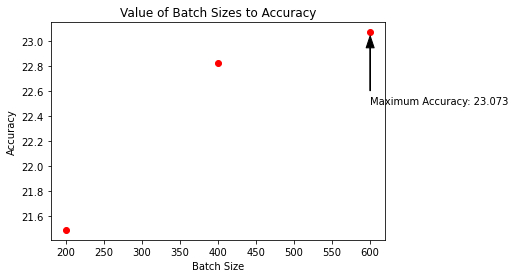

In [ ]:
with open('svm_batch_size.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  line_count = 0
  results = []

  for row in csv_reader:
    if line_count != 0:
      results.append({
          'weights' : row[0],
          'learning_rate' : row[1],
          'reg_param' : row[2],
          'iterations' : row[3],
          'batch_size' : float(row[4]),
          'accuracy' : float(row[5]),
          'runtime' : float(row[6])
      })
    line_count += 1

  n_estimators_list = []
  accuracies = []
  runtimes = []

  for result in results:
      n_estimators_list.append(result['batch_size'])
      accuracies.append(result['accuracy'])
      runtimes.append(result['runtime'])

  plt.plot(n_estimators_list, accuracies, 'ro')

  plt.title('Value of Batch Sizes to Accuracy')
  plt.xlabel('Batch Size')
  plt.ylabel('Accuracy')
  plt.annotate('Maximum Accuracy: 23.073', xy=(600, 23.07), xytext=(600, 22.5),
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
  plt.show()
 # plt.plot(n_estimators_list, runtimes, 'bo')

 # plt.title('Number of Weights to Runtime')
 # plt.xlabel('Number of Weights')
  #plt.ylabel('Runtime')
  #plt.show()

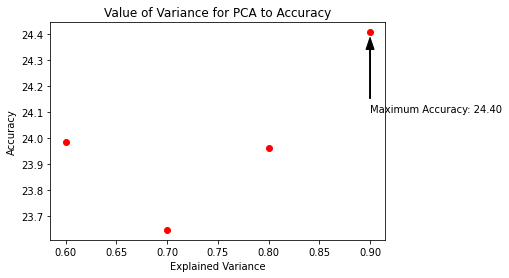

In [ ]:
with open('svm_pca.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  line_count = 0
  results = []

  for row in csv_reader:
    if line_count != 0:
      results.append({
          'weights' : row[0],
          'learning_rate' : row[1],
          'reg_param' : row[2],
          'iterations' : row[3],
          'batch_size' : float(row[4]),
          'accuracy' : float(row[5]),
          'runtime' : float(row[6])
      })
    line_count += 1

  n_estimators_list = []
  accuracies = []
  runtimes = []

  variances= [0.6, 0.7, 0.8, 0.9] 

  for result in results:
      n_estimators_list.append(result['batch_size'])
      accuracies.append(result['accuracy'])
      runtimes.append(result['runtime'])

  plt.plot(variances, accuracies, 'ro')

  plt.title('Value of Variance for PCA to Accuracy')
  plt.xlabel('Explained Variance')
  plt.ylabel('Accuracy')
  plt.annotate('Maximum Accuracy: 24.40', xy=(0.9, 24.4), xytext=(0.9, 24.1),
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
  plt.show()

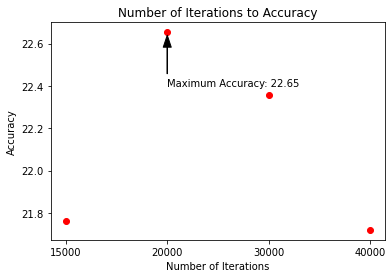

In [ ]:
with open('svm_iterations.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  line_count = 0
  results = []

  for row in csv_reader:
    if line_count != 0:
      results.append({
          'weights' : row[0],
          'learning_rate' : row[1],
          'reg_param' : row[2],
          'iterations' : row[3],
          'batch_size' : float(row[4]),
          'accuracy' : float(row[5]),
          'runtime' : float(row[6])
      })
    line_count += 1

  n_estimators_list = []
  accuracies = []
  runtimes = []

  for result in results:
      n_estimators_list.append(result['iterations'])
      accuracies.append(result['accuracy'])
      runtimes.append(result['runtime'])

  plt.plot(n_estimators_list, accuracies, 'ro')

  plt.title('Number of Iterations to Accuracy')
  plt.xlabel('Number of Iterations')
  plt.ylabel('Accuracy')
  plt.annotate('Maximum Accuracy: 22.65', xy=(1.0, 22.65), xytext=(1.0, 22.4),
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
  plt.show()

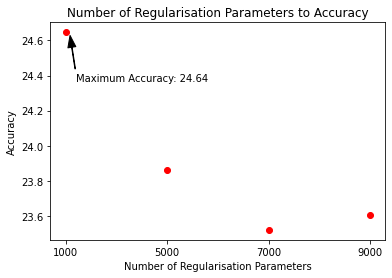

In [ ]:
with open('svm_reg_param.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  line_count = 0
  results = []

  for row in csv_reader:
    if line_count != 0:
      results.append({
          'weights' : row[0],
          'learning_rate' : row[1],
          'reg_param' : row[2],
          'iterations' : row[3],
          'batch_size' : float(row[4]),
          'accuracy' : float(row[5]),
          'runtime' : float(row[6])
      })
    line_count += 1

  n_estimators_list = []
  accuracies = []
  runtimes = []

  for result in results:
      n_estimators_list.append(result['reg_param'])
      accuracies.append(result['accuracy'])
      runtimes.append(result['runtime'])

  plt.plot(n_estimators_list, accuracies, 'ro')

  plt.title('Number of Regularisation Parameters to Accuracy')
  plt.xlabel('Number of Regularisation Parameters')
  plt.ylabel('Accuracy')
  plt.annotate('Maximum Accuracy: 24.64', xy=(0.04, 24.64), xytext=(0.1, 24.37),
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
  plt.show()

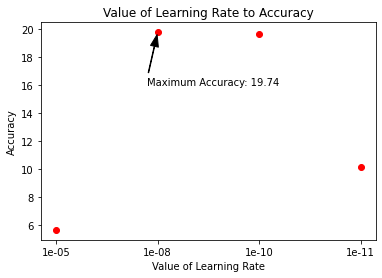

In [ ]:
with open('svm_learning_rates.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  line_count = 0
  results = []

  for row in csv_reader:
    if line_count != 0:
      results.append({
          'weights' : row[0],
          'learning_rate' : row[1],
          'reg_param' : row[2],
          'iterations' : row[3],
          'batch_size' : float(row[4]),
          'accuracy' : float(row[5]),
          'runtime' : float(row[6])
      })
    line_count += 1

  n_estimators_list = []
  accuracies = []
  runtimes = []

  for result in results:
      n_estimators_list.append(result['learning_rate'])
      accuracies.append(result['accuracy'])
      runtimes.append(result['runtime'])

  plt.plot(n_estimators_list, accuracies, 'ro')

  plt.title('Value of Learning Rate to Accuracy')
  plt.xlabel('Value of Learning Rate')
  plt.ylabel('Accuracy')
  plt.annotate('Maximum Accuracy: 19.74', xy=(1.0, 19.74), xytext=(0.9, 16),
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
  plt.show()

In [ ]:
with open('svm_weights.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  line_count = 0
  results = []

  for row in csv_reader:
    if line_count != 0:
      results.append({
          'weights' : (int)row[0],
          'learning_rate' : row[1],
          'reg_param' : row[2],
          'iterations' : row[3],
          'batch_size' : float(row[4]),
          'accuracy' : float(row[5]),
          'runtime' : float(row[6])
      })
    line_count += 1

  n_estimators_list = []
  accuracies = []
  runtimes = []

  for result in results:
      n_estimators_list.append(result['weights'])
      accuracies.append(result['accuracy'])
      runtimes.append(result['runtime'])

  plt.plot(variances, accuracies, 'ro')

  plt.title('Various Sets of Weights to Accuracy')
  plt.xlabel('Set of Weights')
  plt.ylabel('Accuracy')
  plt.annotate('Maximum Accuracy: 24.40', xy=(0.9, 24.4), xytext=(0.9, 24.1),
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
  plt.show()

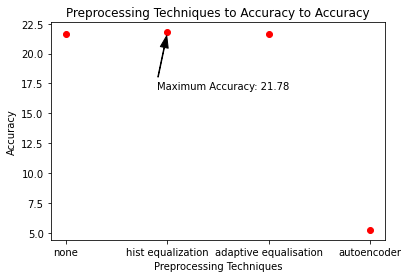

In [20]:
with open('svm_preprocessing.csv') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  line_count = 0
  results = []

  for row in csv_reader:
    if line_count != 0:
      results.append({
          'learning_rate' : row[1],
          'reg_param' : row[2],
          'iterations' : row[3],
          'batch_size' : float(row[4]),
          'accuracy' : float(row[5]),
          'runtime' : float(row[6])
      })
    line_count += 1

  n_estimators_list = []
  accuracies = []
  runtimes = []
  techniques= ['none', 'hist equalization','adaptive equalisation', 'autoencoder' ]

  for result in results:
      n_estimators_list.append(result['iterations'])
      accuracies.append(result['accuracy'])
      runtimes.append(result['runtime'])

  plt.plot(techniques, accuracies, 'ro')

  plt.title('Preprocessing Techniques to Accuracy to Accuracy')
  plt.xlabel('Preprocessing Techniques')
  plt.ylabel('Accuracy')
  plt.annotate('Maximum Accuracy: 21.78', xy=(1.0, 21.7), xytext=(0.9, 17.0),
                arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=8))
  plt.show()